<a href="https://colab.research.google.com/github/sushily1997/ML_Assignments/blob/main/Calibration_Curve_Concept_and_its_implementation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Calibration curve**
####**Introduction**
The score you get from a binary classifier (that outputs a number between 0 and 1.0 is not necessarily a well-calibrated probability. Even some models that provide a method that return the probability prediction can give you poorc estimates of the class probabilities. For these cases, you have to calibrate the predicted probabilities. The tools utilized to calibrate a model are sometimes called calibration curve (Python) and other, reliability diagrams (R).

Some machine learning algorithm already returned their predicted probabilities already calibrated.

* Logistic Regression
* XGB Gradient Boostings for the objective funtions bellow:

> * 'binary:logistic' for bianry classification

> * 'multi:softprob' for multiclass classification






Other algorithms have to calibrate their predicted probabilities. Some examples include neural networks, support vector machines, and decision trees.

**A well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predicted probability value close to 0.8 (confident level), approximately 80% actually belong to the positive class.**

#**Calibration curve**

Bellow are the steps to make calibration curve:

1. the prediction space is discretized into bins

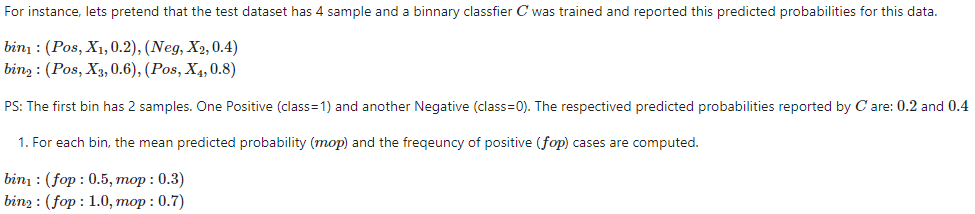

1. The mean predicted probability is plotted against freqeuncy of positive cases

If the model is well calibrated the points will fall near the diagonal line. Below the diagonal: The model has **over-forecast**; the probabilities are too large. Above the diagonal: The model has **under-forecast**; the probabilities are too small.

#**When to calibrate**
Whether or not we want well calibrated probabilities depends entirely on the problem we are trying to solve.

On the cases where you only need to rank observations from most likely to least likely such as user identification or score similarity you do NOT have to calibrate the predicted probability.

For cases where you need to make decisions based on model outputs is recommended to do it:

* credit default probabilities, it may the company's policy to contact every customer whose default risk is over 0.6.

* If your model outputs risk of heart failure in the next 3 months, the doctors (or medical guidelines) may need to act on the people whose risk is above 0.5, to prevent the event from taking place

* Fraud detection, you might decide to take an action based ont the transcation values and the predicted probability
#**Type of calibration**
* Isotonic Calibration (also called Isotonic Regression) fits a piecewise function to the outputs of your original model instead

* Sigmoid Calibration simply means to fit a Logistic Regression classifier using the (0 or 1) outputs from your original model.

**The first one is the most used because tend to have better results.**

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%pylab inline

np.random.seed(0)

from warnings import filterwarnings
filterwarnings('ignore')


from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification

from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve



from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

Populating the interactive namespace from numpy and matplotlib


#**Calibration curve for complex data**
The data has non informative and redundant features.

We are going to compare the predicted probability whithout calibration for differents models. One important thing, is that depend of the data, some classifiers can have already a good predicted probability, and it is not necessary to calibrate. Normally is the case of Logistic Regression, but suprisingly, many times Random Forest also exibited calibrated predicted probailities.

###**Data**

###**In sklearn**
sklearn has a helpful utility function, calibration_curve(), that allows us to examine these relationships quickly. The code is largely lifted from [their docs](https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py), with my own commentary.

For the sake of example, let’s generate a fake dataset comprised of 10k records and of the 20 features, 2 are useful and 2 aren’t.

In [115]:
X, y = make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=3)

Populating the interactive namespace from numpy and matplotlib
As you can see, the breakout of 0/1 values is very nearly 50⁄50

In [116]:
from collections import Counter

Counter(y)

Counter({0: 50001, 1: 49999})

###**split train, test for calibration**
And so splitting out the data like we usually do

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7,
                                                    test_size=.3, random_state=42)

###**Train the models**

In [118]:
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=50,random_state=0)
gbo = GradientBoostingClassifier(n_estimators=50,random_state=0)

We’ll fit a Logistic Regression to our training data



In [119]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train);

Which yields an average predicted value just a bit south of 50⁄50, which is ideal because it lines up with our 0/1 distribution

In [120]:
y_train.mean()

0.4995

Now we’ll express our predictions in terms of Pr(True) and feed it into calibration_curve() along with the correct values of y_train.

In [121]:
n_bins = 10
prob_true = lr.predict_proba(X_train)[:, 1] # results are tuples of (Pr(False), Pr(True))
fraction_of_positives, mean_predicted_value = calibration_curve(y_train, prob_true, n_bins=n_bins)

This n_bins argument is important, because it determines how granularly we examine the quantiles to check “average prediction” vs “proportion of True records.”

Under the hood, the function defaults to creating uniform bins between 0 and 1

In [122]:
bins = np.linspace(0.0, 1.0 + 1e-8, n_bins + 1)
print(bins)

[0.         0.1        0.2        0.3        0.4        0.5
 0.60000001 0.70000001 0.80000001 0.90000001 1.00000001]


And so as a sanity check, we’ll use these bins to interrogate the returned values of fraction_of_positives.

The first bin is in the range (0, 0.1], so we’ll filter down all of our probability predictions within that band. Then use that index to filter down our y_train records. Finally, taking the mean of what’s left gives us the proportion of True records in the first quantile.

In [123]:
y_train[prob_true <= .1].mean()

0.03750974279033515

In [124]:
fraction_of_positives[0]

0.03750974279033515

The same relationship holds for the next bin



In [125]:
y_train[(0.1 < prob_true) & (prob_true <= 0.2)].mean()

0.1334120425029516

In [126]:
fraction_of_positives[1]

0.1334120425029516

and so on…

In [127]:
fraction_of_positives

array([0.03750974, 0.13341204, 0.22625929, 0.3045667 , 0.43638574,
       0.54956808, 0.65765423, 0.75462392, 0.86656353, 0.97531738])

Similarly, we want to look at these same cuts, and see what our average predicted value is.



In [128]:
mean_predicted_value

array([0.03181819, 0.14465401, 0.24690242, 0.34888122, 0.44959801,
       0.54918005, 0.65035769, 0.75169552, 0.85472951, 0.97107626])

In [129]:
prob_true[prob_true <= 0.1].mean()


0.03181818698761661

In [130]:
prob_true[(0.1 < prob_true) & (prob_true <= 0.2)].mean()


0.14465401013871584

##**Creating the Plots**
And so taking these 10 quantile observations and plotting them against one another, we can see a roughly-linear relationship forming. The orange, dashed line represents the perfect relationship where our predictions line up 1-1 with the proportion of positive records.

Couple caveats here, we should expect a Logistic Regression to produce a pretty straight line– after all, the underling mechanism is a linear one.

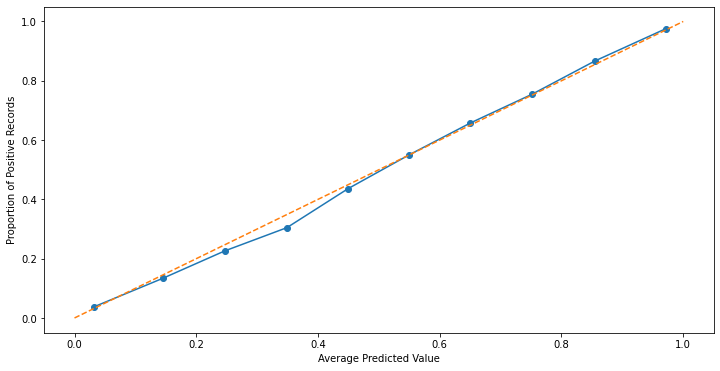

In [131]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_train, prob_true, n_bins=10)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(mean_predicted_value, fraction_of_positives, marker='o')
ax.set_xlabel('Average Predicted Value')
ax.set_ylabel('Proportion of Positive Records')
ax.plot([0, 1], [0, 1], linestyle='--');

However, increasing the number of bins from 10 to 50 reveals that intra-bin errors were more or less cancelling each other out.

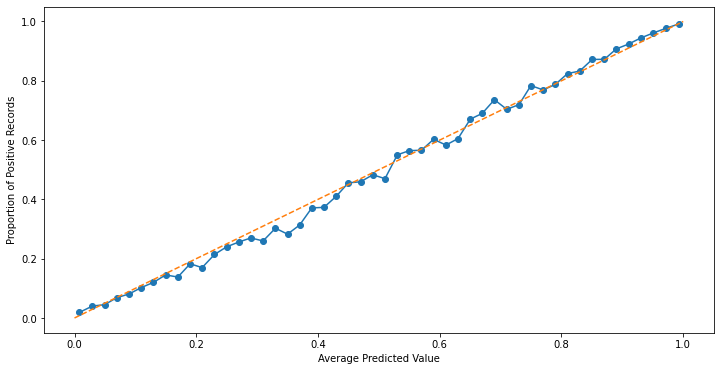

In [132]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_train, prob_true, n_bins=50)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(mean_predicted_value, fraction_of_positives, marker='o')
ax.set_xlabel('Average Predicted Value')
ax.set_ylabel('Proportion of Positive Records')
ax.plot([0, 1], [0, 1], linestyle='--');

Indeed, when we look at a histogram of predicted probabilities, the “above the dotted line” bit between (0, 0.05] makes sense, as our model has a bias of predicting values very close to zero.

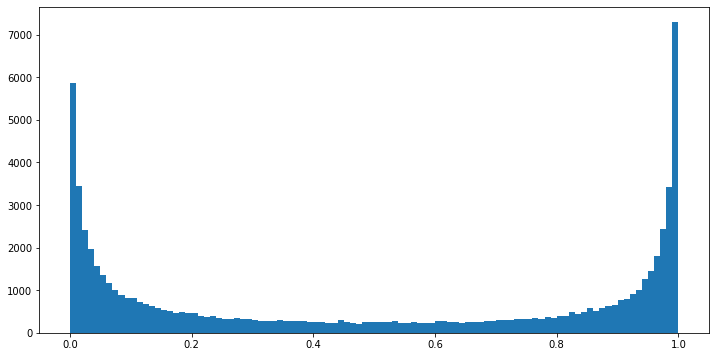

In [133]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(prob_true, bins=100);

Overall, despite being well-calibrated (hugging the dotted line pretty nicely), our model has room for improvements by most measures of accuracy.

###**Calibration curve for all models**

CPU times: user 1min 1s, sys: 419 ms, total: 1min 2s
Wall time: 1min 3s


Text(0.5, 1.0, 'Calibration plots  (reliability curve)')

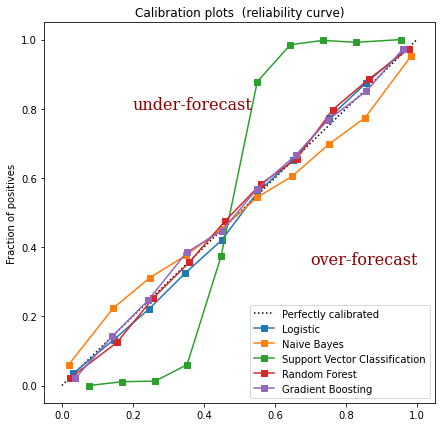

In [135]:
%%time
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.figure(figsize=(7, 7))

axes = plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1 =axes[0]
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest'),
                  (gbo, 'Gradient Boosting')
                 ]:
    
    clf.fit(X_train, y_train)
    
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
        
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)
    
    plt.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))
    
    
plt.text(0.2, 0.8, r'under-forecast', fontdict=font)
plt.text(0.70, 0.35, r'over-forecast', fontdict=font)
plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)');

###**Calibrate with isotonic regression**

CPU times: user 1min 53s, sys: 882 ms, total: 1min 54s
Wall time: 1min 53s


Text(0.5, 1.0, 'Calibration plots  (reliability curve)')

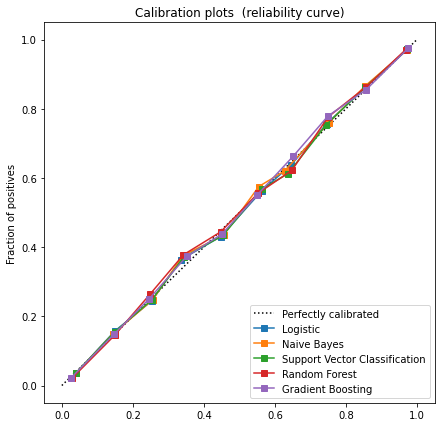

In [136]:
%%time
fig = plt.figure(figsize=(7, 7))

axes = plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1 =axes[0]
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest'),
                  (gbo, 'Gradient Boosting')
                 ]:
    
    clf.fit(X_train, y_train)
    
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
        
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        
    clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
    
    clf_isotonic.fit(X_train, y_train)
    prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
    
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos_isotonic, n_bins=10)
    
    plt.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))
    
plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)');

###**Comparative between isotonic and sigmoid calibration (WIP)**

https://scikit-learn.org/stable/modules/calibration.html#calibration
https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration.html

In [137]:
n_samples = 50000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0,
                  centers=centers, shuffle=False, random_state=42)

y[:n_samples // 2] = 0
y[n_samples // 2:] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

In [138]:
X_train, X_test, y_train, y_test, sw_train, sw_test = \
    train_test_split(X, y, sample_weight, test_size=0.9, random_state=42)

###**Plot the data and the predicted probabilities**

Text(0.5, 1.0, 'Data')

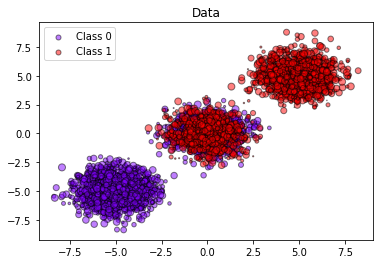

In [139]:
plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50, c=color,
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")